In [4]:
import pandas as pd
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from tqdm import tqdm

# internal utils
from utils import *

In [2]:
# autoreload modified libraries
%load_ext autoreload
%autoreload 2

# Experiment setup

As we don't have real data, let's benchmark the speed of optimization algorithms against ReHLine-PO for the following simulated data (partially copied from [this paper](https://www.math.uwaterloo.ca/~ltuncel/publications/corr2006-19.pdf)):

| Dataset type  | Description  |
|---|---|
| Dense data  | $G = C^T C$ where $C_{ij} \sim Unif(-0.5, 0.5)$|
| Sparse data  | $G = L L^T$ sparse positive semi-definite matrix s.t. $(L_{ij} | L_{ij} \neq 0) \sim Unif(l, r)$ and $\#\{L_{ij} \neq 0\} = \frac{1}{2}N(N-1) \times \rho$ where $\rho$ is a density parameter. |

_Setting:_ solve the following problem
$$\min_{\mathbf{w} \in \mathbb{R}^n} \frac{\alpha}{2} \mathbf{w}^T \mathbf{G} \mathbf{w} - \mathbf{\mu}^T \mathbf{w} + \sum_{i=1}^n \phi_i(w_i), \; \; \; \; \text{s.t. } \mathbf{A w} \leq \mathbf{b}$$

where $\phi_i$-s are piece-wise linear convex functions. Assume for simplicity $\mathbf{w}^{pre} = \mathbf{0}$, i.e. no previous investing was done.

_Compare ReHLine-PO with_:

1. Turning the problem into QP and solve using `MOSEK`, `CVXPY` to solve it.
2. Block Successive Upper bound Minimization algorithm described in [Zhao et al](https://palomar.home.ece.ust.hk/papers/2018/ZhaoPalomar2018%20-%20Markowitz%20options%20portfolio.pdf)
3. `PyPortfolioOpt` (which uses `CVXPY` as its optimization-engine) - no need to run it in the experiment as its eigenvalue finding algo stops working from around $N=120$

## Dense covariance
Let's first check ReHLine-PO's convergence.

Iter 0, dual_objfn = 139.881, primal_objfn = 41.812, xi_diff = 4.15639, beta_diff = 9.27857
Iter 100, dual_objfn = -37.3413, primal_objfn = 38.4575, xi_diff = 0.0380563, beta_diff = 0.109023
Iter 200, dual_objfn = -38.1785, primal_objfn = 38.3667, xi_diff = 0.00127461, beta_diff = 0.00361301
Iter 300, dual_objfn = -38.1797, primal_objfn = 38.3574, xi_diff = 0.000512812, beta_diff = 0.000573124
Iter 400, dual_objfn = -38.1798, primal_objfn = 38.3577, xi_diff = 0.00017445, beta_diff = 0.000658927
*** Iter 449, free variables converge; next test on all variables
Iter 500, dual_objfn = -38.2951, primal_objfn = 38.3312, xi_diff = 0.00102382, beta_diff = 0.00309128
Iter 600, dual_objfn = -38.296, primal_objfn = 38.3154, xi_diff = 0.000375358, beta_diff = 0.000502841
Iter 700, dual_objfn = -38.2961, primal_objfn = 38.3115, xi_diff = 0.000125578, beta_diff = 0.00020028
*** Iter 737, free variables converge; next test on all variables
Iter 800, dual_objfn = -38.3043, primal_objfn = 38.3079, xi_

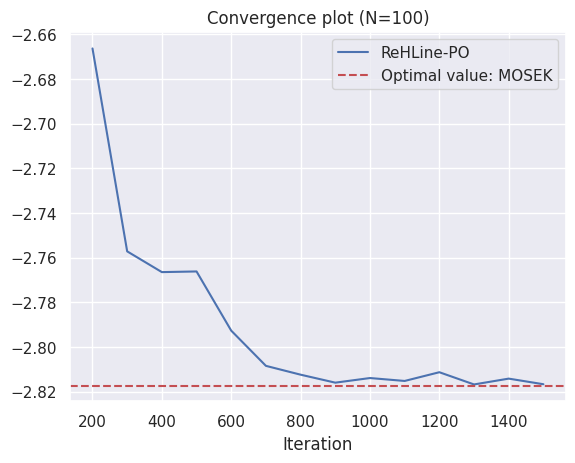

In [10]:
from utils import *
from tqdm import tqdm


N = 100
max_iter = 10000
tol = 1e-4
trace_freq = 100
vp, vm = 0.01*np.ones(N), 0.02*np.ones(N)
risk_aversion = 2.0
lb, ub = -1.0, 1.0

mu = np.random.uniform(-0.5, 0.5, N)
C = np.random.uniform(-0.5, 0.5, (N, N))
cov = C.T @ C

ws_rehline, _rehline_opt = max_quad_util_portf_rehline(N=N, m=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub, tol=tol, max_iter=max_iter, trace_freq=trace_freq, verbose=True)

ws_mosek = max_quad_util_portf_mosek(N=N, m=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub)
util_mosek = eval_quad_util(ws_mosek, N=N, m=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm)

n_iters = len(_rehline_opt.primal_obj_)
plt.plot(range(2*trace_freq, trace_freq*(n_iters+1), trace_freq), _rehline_opt.primal_obj_[1:], label="ReHLine-PO")
plt.axhline(y=util_mosek, color='r', linestyle='--', label="Optimal value: MOSEK")
plt.xlabel("Iteration")
plt.legend()
plt.title(f"Convergence plot (N={N}): dense matrix")
plt.show()

_Remark_: Note that sometimes the ReHLine-PO's objective function goes lower than the optimal value. The reason for this is, technically, the value in the plot isn't $\frac{C}{2} w^T S w - \mu^T w + \sum_i \phi_i(w_i)$, but rather a primal objective with the addition of constraint penalization terms. For details, please check the original ReHLine paper. 

In [4]:
risk_aversion = 2.0
lb, ub = -1.0, 1.0
tol = 1e-4
max_iter = 1000

Ns = range(50, 2000, 50)
n_pts = len(Ns)
n_tries = 10

mean_exec_times_mosek, mean_exec_times_rehline = np.zeros(n_pts), np.zeros(n_pts)
mean_exec_times_cholesky, mean_exec_times_cholesky_inv = np.zeros(n_pts), np.zeros(n_pts)
std_exec_times_mosek, std_exec_times_rehline = np.zeros(n_pts), np.zeros(n_pts)
std_exec_times_cholesky, std_exec_times_cholesky_inv = np.zeros(n_pts), np.zeros(n_pts)

for i, N in tqdm(enumerate(Ns)):
    exec_times_mosek, exec_times_rehline = [], []
    exec_times_cholesky, exec_times_cholesky_inv = [], []
    for _ in range(n_tries):
        N = round(N)
        mu = np.random.uniform(-0.5, 0.5, N)
        C = np.random.uniform(-0.5, 0.5, (N, N))
        cov = C.T @ C
        vp, vm = 0.01*np.ones(N), 0.02*np.ones(N)
    
        start = time.time()
        _L = LA.cholesky(cov)
        end = time.time()
        exec_times_cholesky.append(end - start)

        start = time.time()
        LA.inv(_L)
        end = time.time()
        exec_times_cholesky_inv.append(end - start)

        start = time.time()
        ws_rehline, _ = max_quad_util_portf_rehline(N=N, m=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub, tol=tol, max_iter=max_iter)
        end = time.time()
        exec_times_rehline.append(end - start) 
        
        start = time.time()
        ws_mosek = max_quad_util_portf_mosek(N=N, m=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub)
        end = time.time()
        exec_times_mosek.append(end - start)

    mean_exec_times_mosek[i], std_exec_times_mosek[i] = np.mean(exec_times_mosek), np.std(exec_times_mosek)
    mean_exec_times_rehline[i], std_exec_times_rehline[i] = np.mean(exec_times_rehline), np.std(exec_times_rehline)
    mean_exec_times_cholesky[i], std_exec_times_cholesky[i] = np.mean(exec_times_cholesky), np.std(exec_times_cholesky)
    mean_exec_times_cholesky_inv[i], std_exec_times_cholesky_inv[i] = np.mean(exec_times_cholesky_inv), np.std(exec_times_cholesky_inv)

39it [10:08, 15.61s/it]


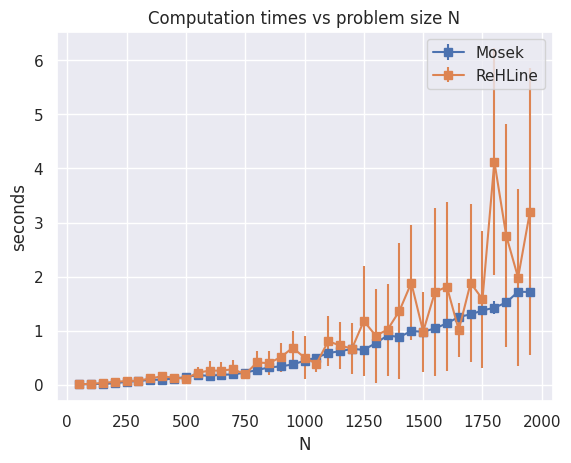

In [8]:
plt.errorbar(Ns, mean_exec_times_mosek, yerr=std_exec_times_mosek, label="Mosek", marker='s')
plt.errorbar(Ns, mean_exec_times_rehline, yerr=std_exec_times_rehline, label="ReHLine", marker='s')
# plt.errorbar(Ns, mean_exec_times_cholesky, yerr=std_exec_times_cholesky, label="Cholesky")
# plt.errorbar(Ns, mean_exec_times_cholesky_inv, yerr=std_exec_times_cholesky_inv, label="Cholesky-inv")
plt.xlabel("N")
plt.ylabel("seconds")
plt.title("Computation times vs problem size N")
plt.legend()
plt.show()

In [36]:
risk_aversion = 2.0
lb, ub = -1.0, 1.0
tol = 1e-4
max_iter = 1000

N = 100
n_pts = len(Ns)
n_tries = 1000
max_iter = 10000

utils_rehline, utils_mosek = np.zeros(n_tries), np.zeros(n_tries)
n_iters_rehline = []
for i in tqdm(range(n_tries)):
    mu = np.random.uniform(-0.5, 0.5, N)
    C = np.random.uniform(-0.5, 0.5, (N, N))
    cov = C.T @ C
    vp, vm = 0.01*np.ones(N), 0.02*np.ones(N)

    ws_rehline, _rehline_opt = max_quad_util_portf_rehline(N=N, m=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub, tol=tol, max_iter=max_iter)
    ws_mosek = max_quad_util_portf_mosek(N=N, m=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub)

    util_rehline = eval_quad_util(ws_rehline, N=N, m=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm)
    util_mosek = eval_quad_util(ws_mosek, N=N, m=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm)
    utils_rehline[i], utils_mosek[i] = util_rehline, util_mosek
    n_iters_rehline.append(_rehline_opt.n_iter_)

100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.20it/s]


In [37]:
print("ReHLine didn't converge in {} out of {} tries".format(
    sum(n_iter == max_iter for n_iter in n_iters_rehline), n_tries))

ReHLine didn't converge in 94 out of 1000 tries


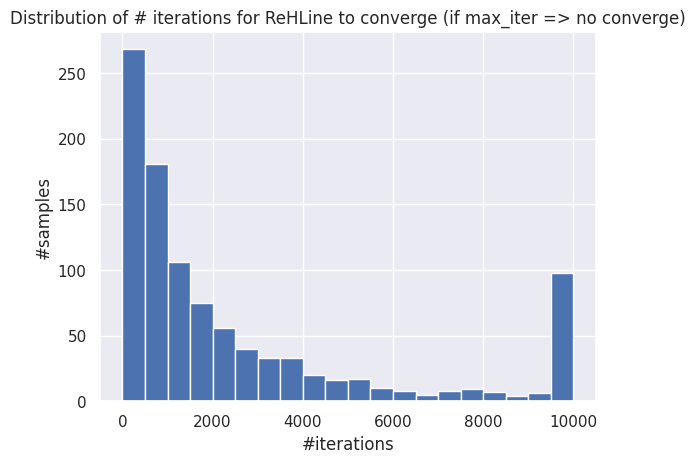

In [38]:
plt.hist(n_iters_rehline, bins=20)
plt.title("Distribution of # iterations for ReHLine to converge (if max_iter => no converge)")
plt.xlabel("#iterations")
plt.ylabel("#samples")
plt.show()

## Sparse covariance

Iter 0, dual_objfn = 109.033, primal_objfn = 76.1218, xi_diff = 2.97694, beta_diff = 12.2637
Iter 10, dual_objfn = 9.01915, primal_objfn = 75.6991, xi_diff = 0.767203, beta_diff = 0.460411
Iter 20, dual_objfn = -25.4989, primal_objfn = 75.7619, xi_diff = 0.371582, beta_diff = 0.316455
Iter 30, dual_objfn = -42.5923, primal_objfn = 74.1643, xi_diff = 0.246209, beta_diff = 0.193673
Iter 40, dual_objfn = -53.8088, primal_objfn = 74.1518, xi_diff = 0.169672, beta_diff = 0.126361
Iter 50, dual_objfn = -60.7681, primal_objfn = 74.0536, xi_diff = 0.126872, beta_diff = 0.124764
Iter 60, dual_objfn = -64.9874, primal_objfn = 74.4414, xi_diff = 0.11474, beta_diff = 0.153216
Iter 70, dual_objfn = -67.5546, primal_objfn = 74.6625, xi_diff = 0.0682555, beta_diff = 0.132821
Iter 80, dual_objfn = -69.3013, primal_objfn = 73.9051, xi_diff = 0.0555933, beta_diff = 0.0831905
Iter 90, dual_objfn = -70.3651, primal_objfn = 73.3613, xi_diff = 0.0492084, beta_diff = 0.170676
Iter 100, dual_objfn = -71.159, 

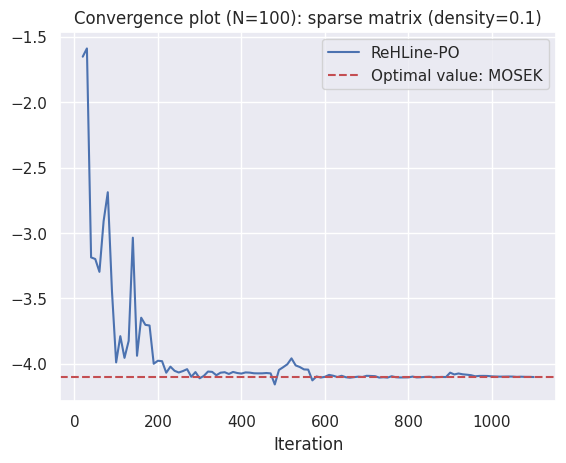

In [7]:
from utils import *

N = 100
max_iter = 10000
tol = 1e-4
trace_freq = 10
vp, vm = 0.01*np.ones(N), 0.02*np.ones(N)
risk_aversion = 2.0
lb, ub = -1.0, 1.0
density = 0.1

mu = np.random.uniform(-0.5, 0.5, N)
cov = random_sparse_spd_matrix(dim=N, density=density)

ws_rehline, _rehline_opt = max_quad_util_portf_rehline(N=N, m=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub, tol=tol, max_iter=max_iter, trace_freq=trace_freq, verbose=True)

ws_mosek = max_quad_util_portf_mosek(N=N, m=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub)
util_mosek = eval_quad_util(ws_mosek, N=N, m=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm)

n_iters = len(_rehline_opt.primal_obj_)
plt.plot(range(2*trace_freq, trace_freq*(n_iters+1), trace_freq), _rehline_opt.primal_obj_[1:], label="ReHLine-PO")
plt.axhline(y=util_mosek, color='r', linestyle='--', label="Optimal value: MOSEK")
plt.xlabel("Iteration")
plt.legend()
plt.title(f"Convergence plot (N={N}): sparse matrix (density={density})")
plt.show()

In [5]:
risk_aversion = 2.0
lb, ub = -1.0, 1.0
tol = 1e-4
max_iter = 1000

Ns = range(50, 2000, 50)
n_pts = len(Ns)
n_tries = 10
density = 0.2

mean_exec_times_mosek, mean_exec_times_rehline = np.zeros(n_pts), np.zeros(n_pts)
mean_exec_times_cholesky, mean_exec_times_cholesky_inv = np.zeros(n_pts), np.zeros(n_pts)
std_exec_times_mosek, std_exec_times_rehline = np.zeros(n_pts), np.zeros(n_pts)
std_exec_times_cholesky, std_exec_times_cholesky_inv = np.zeros(n_pts), np.zeros(n_pts)

for i, N in tqdm(enumerate(Ns)):
    exec_times_mosek, exec_times_rehline = [], []
    exec_times_cholesky, exec_times_cholesky_inv = [], []
    for _ in range(n_tries):
        N = round(N)
        mu = np.random.uniform(-0.5, 0.5, N)
        cov = random_sparse_spd_matrix(dim=N, density=density)
        while np.linalg.matrix_rank(cov) < N:
            cov = random_sparse_spd_matrix(dim=N, density=density)
        vp, vm = 0.01*np.ones(N), 0.02*np.ones(N)
    
        start = time.time()
        _L = LA.cholesky(cov)
        end = time.time()
        exec_times_cholesky.append(end - start)

        start = time.time()
        LA.inv(_L)
        end = time.time()
        exec_times_cholesky_inv.append(end - start)

        start = time.time()
        ws_rehline, _ = max_quad_util_portf_rehline(N=N, m=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub, tol=tol, max_iter=max_iter)
        end = time.time()
        exec_times_rehline.append(end - start) 
        
        start = time.time()
        ws_mosek = max_quad_util_portf_mosek(N=N, m=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub)
        end = time.time()
        exec_times_mosek.append(end - start)

    mean_exec_times_mosek[i], std_exec_times_mosek[i] = np.mean(exec_times_mosek), np.std(exec_times_mosek)
    mean_exec_times_rehline[i], std_exec_times_rehline[i] = np.mean(exec_times_rehline), np.std(exec_times_rehline)
    mean_exec_times_cholesky[i], std_exec_times_cholesky[i] = np.mean(exec_times_cholesky), np.std(exec_times_cholesky)
    mean_exec_times_cholesky_inv[i], std_exec_times_cholesky_inv[i] = np.mean(exec_times_cholesky_inv), np.std(exec_times_cholesky_inv)

39it [11:26, 17.59s/it]


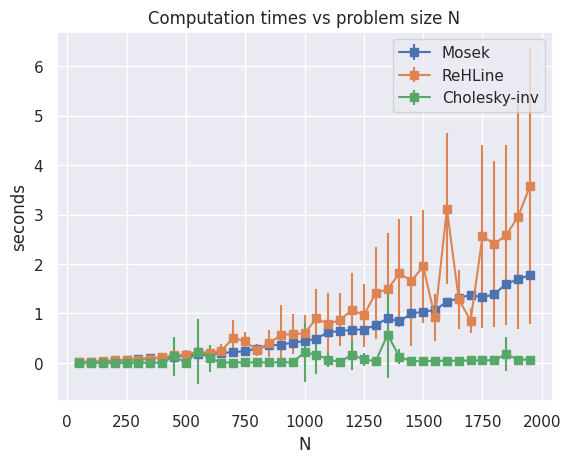

In [9]:
plt.errorbar(Ns, mean_exec_times_mosek, yerr=std_exec_times_mosek, label="Mosek", marker='s')
plt.errorbar(Ns, mean_exec_times_rehline, yerr=std_exec_times_rehline, label="ReHLine", marker='s')
# plt.errorbar(Ns, mean_exec_times_cholesky, yerr=std_exec_times_cholesky, label="Cholesky")
plt.errorbar(Ns, mean_exec_times_cholesky_inv, yerr=std_exec_times_cholesky_inv, label="Cholesky-inv", marker='s')
plt.xlabel("N")
plt.ylabel("seconds")
plt.title("Computation times vs problem size N")
plt.legend()
plt.show()